# Collaborative Filtering

Leonie Heiduk (489913@student.saxion.nl)

Sang Pham (414845@student.saxion.nl)

In [3]:
from IPython.core.display import HTML
from movie_display import movie_display
import ipywidgets as widgets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from IPython.display import display

from sklearn.metrics.pairwise import cosine_similarity

## Dataset analysis

To get insight in the ratings given, we show graphs in which the characteristics of the ratings are shown:
* Distribution of how often a movie is rated
* Distribution of how often a specific rating was given
* Distribution of the average ratings given to a movie 
* Distribution of the average ratings given by the users 
* Average Rating per Movie and amount of times rated

In [4]:
# Read in all Datafiles into DataFrames

def dateparse(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

imdbdataDF = pd.read_json('./dataset/imdbdata.json', orient='columns')
linksDF = pd.read_csv('./dataset/links.csv', delimiter=',', quotechar='"', encoding='UTF-8', index_col='movieId')
moviesDF = pd.read_csv('./dataset/movies.csv', delimiter=',', quotechar='"', encoding='UTF-8')
ratingsDF = pd.read_csv('./dataset/ratings.csv', delimiter=',', quotechar='"', encoding='UTF-8', index_col='movieId', parse_dates=['timestamp'], date_parser=dateparse)
tagsDF = pd.read_csv('./dataset/tags.csv', delimiter=',', quotechar='"', encoding='UTF-8', index_col='movieId', parse_dates=['timestamp'], date_parser=dateparse)

display(imdbdataDF.head())
display(linksDF.head())
display(moviesDF.head())
display(tagsDF.head())
display(ratingsDF)

,imdbId,Title,Year,imdbRating,imdbVotes,Rated,Released,Runtime,Genre,Actors,Director,Writer,Plot,Language,Country,Awards,Poster,Production
0,114709,Toy Story,1995,8.3,"666,855",G,22 Nov 1995,81 min,"Animation, Adventure, Comedy","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,"John Lasseter (original story by), Pete Docter...",A cowboy doll is profoundly threatened and jea...,English,USA,Nominated for 3 Oscars. Another 23 wins & 18 n...,https://images-na.ssl-images-amazon.com/images...,Buena Vista
1,113497,Jumanji,1995,6.9,"223,000",PG,15 Dec 1995,104 min,"Action, Adventure, Family","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,"Jonathan Hensleigh (screenplay), Greg Taylor (...",When two kids find and play a magical board ga...,"English, French",USA,4 wins & 9 nominations.,https://images-na.ssl-images-amazon.com/images...,Sony Pictures Home Entertainment
2,113228,Grumpier Old Men,1995,6.6,"20,100",PG-13,22 Dec 1995,101 min,"Comedy, Romance","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...",John and Max resolve to save their beloved bai...,English,USA,2 wins & 2 nominations.,https://images-na.ssl-images-amazon.com/images...,Warner Home Video
3,114885,Waiting to Exhale,1995,5.7,"7,769",R,22 Dec 1995,124 min,"Comedy, Drama, Romance","Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Terry McMillan (novel), Terry McMillan (screen...","Based on Terry McMillan's novel, this film fol...",English,USA,8 wins & 8 nominations.,https://images-na.ssl-images-amazon.com/images...,Twentieth Century Fox Home Entertainment
4,113041,Father of the Bride Part II,1995,5.9,"27,815",PG,08 Dec 1995,106 min,"Comedy, Family, Romance","Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,"Albert Hackett (screenplay), Frances Goodrich ...",George Banks must deal not only with the pregn...,English,USA,Nominated for 1 Golden Globe. Another 1 win & ...,https://images-na.ssl-images-amazon.com/images...,Disney


,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,tag,timestamp
movieId,,,
339,15,sandra 'boring' bullock,2006-01-29 13:29:30
1955,15,dentist,2007-10-26 23:44:21
7478,15,Cambodia,2007-02-04 04:49:57
32892,15,Russian,2007-02-04 22:59:26
34162,15,forgettable,2006-03-03 14:16:05


,userId,rating,timestamp
movieId,,,
31,1,2.5,2009-12-14 03:52:24
1029,1,3.0,2009-12-14 03:52:59
1061,1,3.0,2009-12-14 03:53:02
1129,1,2.0,2009-12-14 03:53:05
1172,1,4.0,2009-12-14 03:53:25
...,...,...,...
6268,671,2.5,2003-10-08 04:16:10
6269,671,4.0,2003-10-03 04:46:41
6365,671,4.0,2003-12-09 04:26:03


### Distribution of how often a movie is rated

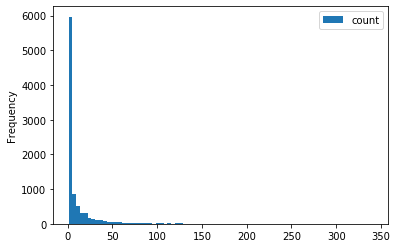

In [5]:
amtOfRatings = ratingsDF[['timestamp']].groupby('movieId').count().rename(columns={'timestamp': 'count'})
amtOfRatings.plot.hist(bins=80)

In [6]:
amtOfRatings.describe()

,count
count,9066.000000
mean,11.030664
std,24.050800
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,341.000000


### Distribution of how often a specific rating was given
e.g. for each rating given, count how often it occured

Text(0, 0.5, 'occurences')

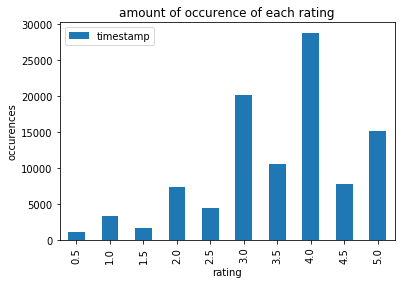

In [7]:
ratingsAndOccurences = ratingsDF[['rating', 'timestamp']].groupby('rating').count()
ratingsAndOccurences.plot(kind='bar', title='amount of occurence of each rating')
plt.ylabel('occurences')

### Distribution of the average ratings given to a movie
e.g. get the average of the ratings of each movie and check how often each average occurs

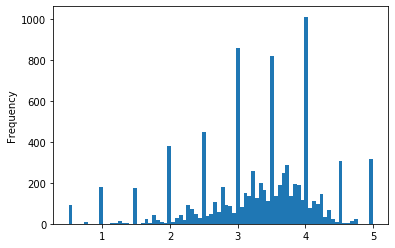

In [8]:
avgRatingPerMovie = ratingsDF['rating'].groupby('movieId').mean()
avgRatingPerMovie.plot.hist(bins=80)

### Distribution of the average ratings given by the users
e.g. get the average of the ratings of each user and check how often each average occurs

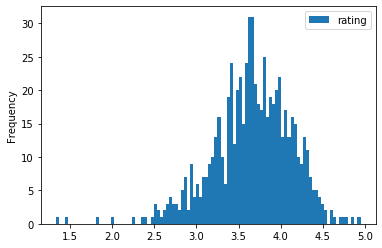

In [9]:
avgRatingPerUser = ratingsDF[['userId', 'rating']].groupby('userId').mean()
avgRatingPerUser.plot.hist(bins=100)

### Amount of Times each user has rated movies

In [15]:
amtRatedByUser = ratingsDF[['rating', 'userId']].groupby('userId').count().rename(columns={'rating': 'count'})
display(amtRatedByUser)
amtRatedByUser.describe()

,count
userId,
1,20
2,76
3,51
4,204
5,100
...,...
667,68
668,20
669,37


,count
count,671.000000
mean,149.037258
std,231.226948
min,20.000000
25%,37.000000
50%,71.000000
75%,161.000000
max,2391.000000


In [19]:
amtRatedByUser[amtRatedByUser['count'] == 2391]

,count
userId,
547,2391


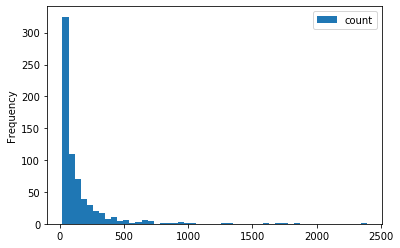

In [22]:
amtRatedByUser.plot.hist(bins=50)

### Average Rating per Movie and amount of times rated

,avgRating,nrOfRatings
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56
...,...,...
161944,5.000000,1
162376,4.500000,1
162542,5.000000,1


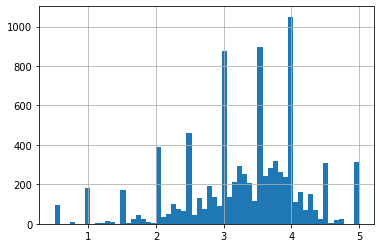

In [23]:
ratings = pd.DataFrame(ratingsDF.groupby('movieId')['rating'].mean()).rename(columns={'rating':'avgRating'})
ratings['nrOfRatings'] = ratingsDF.groupby('movieId')['rating'].count()
display(ratings)
ratings['avgRating'].hist(bins=60)

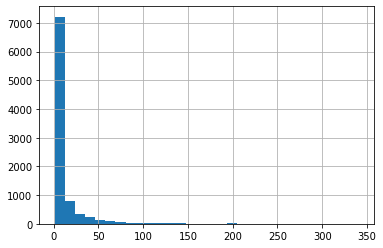

In [24]:
ratings['nrOfRatings'].hist(bins=30)

In the histogram above, we can clearly see that most movies barely have any ratings. The movies with the most ratings are the ones most famous/most watched. 
To check the relation between the number of ratings and the average rating given to a movie, we plot them both into a scatterplot and check the correlation value. 


 Correlation of Average Rating and Number of Ratings:  0.13082726621823274


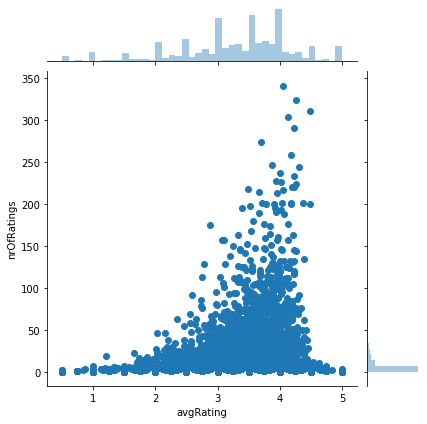

In [25]:
corrVal = ratings['avgRating'].corr(ratings['nrOfRatings'])
print('\n Correlation of Average Rating and Number of Ratings: ', corrVal)

sns.jointplot(x='avgRating', y='nrOfRatings', data=ratings)

We can clearly see that we have a positive correlation between those two values, meaning the more ratings we have, the higher the average rating will be.

In [26]:
# Get the ten most rated movies
mostRated = ratings.sort_values('nrOfRatings', ascending=False).head(10)

mostRated = mostRated.merge(moviesDF, on = 'movieId')
mostRated

,movieId,avgRating,nrOfRatings,title,genres
0,356,4.054252,341,Forrest Gump (1994),Comedy|Drama|Romance|War
1,296,4.256173,324,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,318,4.487138,311,"Shawshank Redemption, The (1994)",Crime|Drama
3,593,4.138158,304,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,260,4.221649,291,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,480,3.706204,274,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
6,2571,4.183398,259,"Matrix, The (1999)",Action|Sci-Fi|Thriller
7,1,3.872470,247,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,527,4.303279,244,Schindler's List (1993),Drama|War
9,589,4.006329,237,Terminator 2: Judgment Day (1991),Action|Sci-Fi


## User-user recommendations
Find similar users (users that rate items the same way you do) and recommend items they liked

Derive user-user similarity matrices based on: 
* Cosine similarity
* Pearson similarity
* Adjusted cosine similarity

Give N (configurable) recommendations for a given user U (configurable) derived from the ratings of the 10 most similar users for each of these similarities.

### User-Item matrix
Generating a user-item-matrix, so for each user, we have all the movies he has or has not rated (= NaN) and the rating he has given.

In [28]:
userItemMatrix = ratingsDF.reset_index().drop(['timestamp'], axis=1)
userItemMatrix = userItemMatrix.pivot(index='userId', columns='movieId', values='rating')
userItemMatrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cosine Similarity

In [29]:
def getCosineSimilarity(matrix):
    """ Returns the Cosine similarity matrix for a given matrix input
        Returns user-user for a user-item matrix
        Return item-item for a item-user matrix
    """
    
    # Fill NaN Values with 0 for Cosine Similarity
    nullMatrix = matrix.fillna(0)
    cosineSimilarity = cosine_similarity(nullMatrix, nullMatrix)

    # Fill Diagonal (Correlation of each user/movie with him-/itself) with 0, so we don't 
    # recommend the movies he already watched/so we don't recommend the exact same movie:
    np.fill_diagonal(cosineSimilarity, 0) 
    
    cosineSimilarityDF = pd.DataFrame(cosineSimilarity,index=nullMatrix.index)
    cosineSimilarityDF.columns=nullMatrix.index
    return cosineSimilarityDF

In [30]:
userCosineSimilarityDF = getCosineSimilarity(userItemMatrix)
userCosineSimilarityDF

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,0.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,0.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,0.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,0.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.425462,0.124562,0.088735,0.058252,0.000000,0.232051,0.069005,0.066412,0.032653,...,0.342283,0.050754,0.074080,0.124214,0.351207,0.000000,0.091597,0.018416,0.153111,0.127995
668,0.000000,0.084646,0.124911,0.068483,0.042926,0.019563,0.058773,0.112366,0.194493,0.098561,...,0.074089,0.059010,0.093021,0.082525,0.114487,0.091597,0.000000,0.000000,0.178017,0.135387
669,0.062917,0.024140,0.080984,0.104309,0.038358,0.024583,0.073151,0.055143,0.029291,0.060549,...,0.015960,0.025953,0.077927,0.101707,0.028773,0.018416,0.000000,0.000000,0.042609,0.085202


### Pearson Similarity
Calculate the average rating for each user and save in new column so we can later manually check if our computation worked. E.g. Row 5 Column 3 should have the value 4 - 3.91 = 0.09.

In [31]:
def getPearsonSimilarity(matrix):
    """ Returns the Pearson similarity matrix for a given matrix input
        Returns user-user for a user-item matrix
        Return item-item for a item-user matrix
    """
    # Substract the Mean of each Row from each item of the dataframe:
    matrixMinusMean = matrix.sub(matrix.mean(axis=1), axis=0)
    matrixMinusMean = matrixMinusMean.fillna(0)
    
    pearsonSimilarity = cosine_similarity(matrixMinusMean, matrixMinusMean)

    # Fill Diagonal (Correlation of each user/movie with him-/itself) with 0, so we don't 
    # recommend the movies he already watched/so we don't recommend the exact same movie:
    np.fill_diagonal(pearsonSimilarity, 0) 

    pearsonSimilarityDF = pd.DataFrame(pearsonSimilarity,index=matrixMinusMean.index)
    pearsonSimilarityDF.columns=matrixMinusMean.index
    
    return pearsonSimilarityDF

In [32]:
check = userItemMatrix.copy()
check['avgRating'] = check.mean(axis=1)
print('\n Row 5 Column 3 has the Value 4 and the AvgRating of 3.91 which would give us 0.09 after the substraction:')
display(check)

# Substract the Mean of each Row from each item of the dataframe:
userItemMatrixMinusMean = userItemMatrix.sub(userItemMatrix.mean(axis=1), axis=0).fillna(0)
display(userItemMatrixMinusMean)


 Row 5 Column 3 has the Value 4 and the AvgRating of 3.91 which would give us 0.09 after the substraction:


movieId,1,2,3,4,5,6,7,8,9,10,...,161155,161594,161830,161918,161944,162376,162542,162672,163949,avgRating
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.550000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.486842
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.568627
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.348039
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.647059
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.750000
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.351351


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,-0.348039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.09,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.0,0.00,0.0,0.0,0.352941,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* The negative values represent negative ratings
* Positive values represent positive ratings
* The value 0 is now the average rating for a user

In [33]:
userPearsonSimilarityDF = getPearsonSimilarity(userItemMatrix)
userPearsonSimilarityDF

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.003620,-0.002274,0.000000,-0.070321,0.000000,0.042632,0.000000,...,0.000000,0.000000,0.018643,0.001031,0.000000,0.000000,0.000000,0.044095,0.000000,-0.013096
2,0.000000,0.000000,-0.001852,-0.004854,0.012639,0.000000,0.042691,0.021066,0.011109,-0.007989,...,-0.018248,-0.021546,0.018902,-0.058952,0.028515,-0.106828,-0.007999,-0.041628,-0.090233,0.056258
3,0.000000,-0.001852,0.000000,0.018594,-0.025903,-0.063200,0.054900,0.026488,-0.036187,0.038021,...,0.044297,0.019581,0.070702,0.030669,0.143705,0.096713,0.027451,0.089297,-0.009815,0.062276
4,0.003620,-0.004854,0.018594,0.000000,0.010801,0.019224,0.057519,0.055430,-0.010442,0.005126,...,0.011978,0.006569,0.027687,0.092092,0.021334,0.040833,0.018428,0.028642,0.019848,0.032749
5,-0.002274,0.012639,-0.025903,0.010801,0.000000,-0.005843,-0.015075,-0.038886,0.013708,0.030500,...,0.046134,0.001903,0.001620,0.036819,-0.038269,-0.019537,-0.071721,0.003760,-0.029455,-0.036814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,-0.106828,0.096713,0.040833,-0.019537,0.000000,0.048268,0.023800,0.042599,0.036776,...,0.000489,0.000871,0.037650,0.019787,0.094050,0.000000,0.087069,-0.003261,-0.005467,0.035538
668,0.000000,-0.007999,0.027451,0.018428,-0.071721,-0.006876,-0.015626,0.011822,0.054536,0.026691,...,-0.002541,0.026407,0.043421,0.026688,0.071970,0.087069,0.000000,0.000000,0.086991,0.028488
669,0.044095,-0.041628,0.089297,0.028642,0.003760,-0.005780,0.037506,-0.009158,0.004907,-0.009258,...,0.003813,0.006498,0.045351,0.079319,-0.010331,-0.003261,0.000000,0.000000,0.020958,0.045097


### Adjusted cosine similarity

In [34]:
def getAdjCosineSimi(matrix):
    """ Returns the Adjusted Cosine Similarity matrix for a given matrix input
        Returns user-user for a user-item matrix
        Return item-item for a item-user matrix
    """
    
   # Substract the Mean of each Column from each item of the dataframe:
    matrixMinusMeanCol = matrix-matrix.mean()
    matrixMinusMeanCol = matrixMinusMeanCol.fillna(0)
    
    adjustedCosine = cosine_similarity(matrixMinusMeanCol, matrixMinusMeanCol)

    # Fill Diagonal with 0
    np.fill_diagonal(adjustedCosine, 0) 

    adjustedSimilarityDF = pd.DataFrame(adjustedCosine,index=matrixMinusMeanCol.index)
    adjustedSimilarityDF.columns=matrixMinusMeanCol.index
    return adjustedSimilarityDF

In [35]:
userAdjustedSimilarityDF = getAdjCosineSimi(userItemMatrix)
userAdjustedSimilarityDF

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,-0.042928,-0.020326,0.000000,-0.084835,0.000000,0.056693,0.000000,...,0.000000,0.000000,0.001404,0.002595,0.000000,0.000000,0.000000,0.000023,0.000000,0.021158
2,0.000000,0.000000,0.026386,-0.018799,0.014673,0.000000,0.040012,-0.022239,0.001264,-0.023076,...,-0.011616,0.006937,0.002182,-0.062952,-0.079717,-0.147949,-0.042216,-0.011552,-0.115512,0.042947
3,0.000000,0.026386,0.000000,-0.017612,-0.030283,-0.040315,-0.028884,-0.029348,-0.054177,-0.006088,...,-0.055113,0.007258,-0.011623,-0.032968,0.194814,0.046531,-0.057462,0.103936,-0.040322,-0.001326
4,-0.042928,-0.018799,-0.017612,0.000000,0.023250,0.008572,-0.046809,0.004820,-0.012379,-0.031362,...,-0.024827,-0.007848,0.022981,0.028751,-0.034598,0.005869,-0.000343,-0.010801,0.011823,0.027860
5,-0.020326,0.014673,-0.030283,0.023250,0.000000,0.010561,-0.021507,-0.011979,-0.006786,0.038089,...,0.025104,0.000131,0.049178,0.065194,-0.051955,-0.022723,-0.058358,0.037019,0.001900,-0.017869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,-0.147949,0.046531,0.005869,-0.022723,0.000000,-0.030899,0.010166,0.015988,0.030009,...,-0.025333,-0.003387,0.005318,0.026711,0.067899,0.000000,0.051939,-0.009879,-0.021533,-0.009791
668,0.000000,-0.042216,-0.057462,-0.000343,-0.058358,-0.008218,-0.047264,-0.020295,0.045056,0.099651,...,-0.054134,-0.011764,0.012849,-0.020612,-0.013071,0.051939,0.000000,0.000000,0.043876,-0.003472
669,0.000023,-0.011552,0.103936,-0.010801,0.037019,-0.009565,-0.022927,-0.024653,0.000063,0.022642,...,0.023111,0.014585,0.054487,0.027426,-0.008879,-0.009879,0.000000,0.000000,0.053488,0.039410


### Create Recommendations
Give N (configurable) recommendations for a given user U (configurable) derived from the ratings of the 10 most similar users for each of these similarities.

Note:
* In the first round, the number one user recommended for user number 1 was user number 1, since in the matrix each user correlates with himself by 1. To fix this issue, I went back to where the Dataframes were created and just filled the diagonal values with 0 instead. 

In [39]:
def getTopNSimilarities(n, the_id, df):
    """ Get top n similar users to a given user ID. 
        Input: 
        n = amount of results
        the_id = user ID to find similar users to
        df = dataframe with similarity values in it (e.g. cosine, pearson, ...)
    """
    
    similarities = df.loc[the_id , : ]
    
    topN_id = similarities.sort_values(ascending=False)[:n].index
    topNSim = similarities.sort_values(ascending=False)[:n]
    
    topN = {'id': topN_id, 'similarity': topNSim}
    topN = pd.DataFrame(topN, columns=['similarity']).reset_index()
        
    return topN

testitest = getTopNSimilarities(10,1,userCosineSimilarityDF)
testitest

,userId,similarity
0,325,0.371852
1,634,0.194093
2,341,0.162819
3,310,0.157524
4,207,0.152746
5,35,0.130585
6,195,0.122647
7,485,0.114021
8,130,0.112817
9,229,0.112575


In [44]:
def getTopNsimilarUsers(n, u, df):
    
    """ Get top n similar users to a given user. 
        Input: 
        n = amount of results
        u = user to find similar users to
        df = dataframe with similarity values in it (e.g. cosine, pearson, ...)
    """
    
    usersSimilarities = df.loc[u , : ]
    
    topNUser = usersSimilarities.sort_values(ascending=False)[:n].index
    topNSim = usersSimilarities.sort_values(ascending=False)[:n]
    
    topN = {'userId': topNUser, 'similarity': topNSim}
    topN = pd.DataFrame(topN, columns=['similarity']).reset_index()
        
    return topN


# Testing
# Test function with each of the similarity dataframes. Get Top 10 for user 1:

cosinetest = getTopNsimilarUsers(10, 1, userCosineSimilarityDF)
print('\n\n Top 10 with Cosine Similarity:')
display(cosinetest)

pearsontest = getTopNsimilarUsers(10,1,userPearsonSimilarityDF)
print('\n\n Top 10 with Pearson Similarity:')
display(pearsontest)

adjCosine = getTopNsimilarUsers(10,1,userAdjustedSimilarityDF)
print('\n\n Top 10 with Adjusted Cosine Similarity:')
display(adjCosine)



 Top 10 with Cosine Similarity:


,userId,similarity
0,325,0.371852
1,634,0.194093
2,341,0.162819
3,310,0.157524
4,207,0.152746
5,35,0.130585
6,195,0.122647
7,485,0.114021
8,130,0.112817
9,229,0.112575




 Top 10 with Pearson Similarity:


,userId,similarity
0,35,0.192699
1,197,0.191875
2,539,0.149320
3,68,0.140930
4,420,0.110344
5,320,0.100558
6,87,0.093835
7,606,0.078043
8,280,0.077903
9,390,0.073390




 Top 10 with Adjusted Cosine Similarity:


,userId,similarity
0,35,0.209664
1,68,0.143866
2,197,0.137512
3,207,0.134983
4,394,0.125929
5,604,0.097267
6,420,0.093870
7,390,0.091965
8,634,0.091798
9,439,0.090447


To manually check if the ratings seem similar, we select user 1 and user 35 as our previous test showed high similarity for those two. We are only interested in the movies both of them rated. The output seems valid, since two of the ratings are almost the same.

In [45]:
# Check ratings of two given users to compare:

def checkMovieRatingsInCommon(user_x, user_y):
    
    user_x_string = 'rating_user_'+str(user_x)
    user_y_string = 'rating_user_'+str(user_y)

    user_x = userItemMatrix.loc[user_x , : ]
    user_x = user_x[user_x.notnull()]

    user_y = userItemMatrix.loc[user_y , : ]
    user_y = user_y[user_y.notnull()]

    user_x_same = user_x[user_x.index.isin(user_y.index)]
    user_y_same = user_y[user_y.index.isin(user_x.index)]
    
    #result = pd.concat([user_x_same, user_y_same], axis=1)
    ratings = user_x_same.to_frame(name =user_x_string).join(user_y_same.to_frame(name=user_y_string)).reset_index()
    result = ratings.merge(moviesDF, on = 'movieId')
    
    return result
    
# Testing
cosineResult = checkMovieRatingsInCommon(1,cosinetest.iloc[0][0])
print('\n Compare Ratings of same movie for Top N Cosine:')
display(cosineResult)
pearsonResult = checkMovieRatingsInCommon(1,pearsontest.iloc[0][0])
print('\n Compare Ratings of same movie for Top N Pearson:')
display(pearsonResult)
adjcosineResult = checkMovieRatingsInCommon(1,adjCosine.iloc[0][0])
print('\n Compare Ratings of same movie for Top N Adjusted Cosine:')
display(adjcosineResult)


 Compare Ratings of same movie for Top N Cosine:


,movieId,rating_user_1,rating_user_325.0,title,genres
0,31,2.5,4.5,Dangerous Minds (1995),Drama
1,1061,3.0,3.5,Sleepers (1996),Thriller
2,1129,2.0,3.0,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
3,1172,4.0,2.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
4,1339,3.5,2.5,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
5,1371,2.5,3.5,Star Trek: The Motion Picture (1979),Adventure|Sci-Fi
6,2193,2.0,1.0,Willow (1988),Action|Adventure|Fantasy



 Compare Ratings of same movie for Top N Pearson:


,movieId,rating_user_1,rating_user_35.0,title,genres
0,1029,3.0,1.5,Dumbo (1941),Animation|Children|Drama|Musical
1,2105,4.0,3.5,Tron (1982),Action|Adventure|Sci-Fi
2,2968,1.0,0.5,Time Bandits (1981),Adventure|Comedy|Fantasy|Sci-Fi



 Compare Ratings of same movie for Top N Adjusted Cosine:


,movieId,rating_user_1,rating_user_35.0,title,genres
0,1029,3.0,1.5,Dumbo (1941),Animation|Children|Drama|Musical
1,2105,4.0,3.5,Tron (1982),Action|Adventure|Sci-Fi
2,2968,1.0,0.5,Time Bandits (1981),Adventure|Comedy|Fantasy|Sci-Fi


In [46]:
def getMovieCandidates(topN, user, scoringDF):
    """  Get Movies from topN similar users, that user has not watched yet
    """
    
    candidates = []
    
    alreadyRated = userItemMatrix.loc[user , : ]
    alreadyRated = alreadyRated[alreadyRated.notnull()]
    
    for index, row in topN.iterrows():
        
        userId = row.userId
        userSimilarity = row.similarity
        
        currUser = userItemMatrix.loc[userId , : ]
        currUser = currUser[currUser.notnull()] # Series: movieId (index) and rating
        
        for movie, rating in currUser.items():
            # if the movie is not already rated by the user we want to recommend for, 
            # we append movieId and rating of that user
            if movie not in alreadyRated.index:
                candidates.append([movie, userId, rating, userSimilarity])
                
    allCandidates = pd.DataFrame(candidates, columns=['movieId', 'userId', 'rating', 'similarity_value'])
    
    #test = allCandidates.groupby('userId').count()
    #print(test) Gives 10 Users - still correct
            
    #print(candidates)
    
    return allCandidates
        
# Testing
candidates = getMovieCandidates(cosinetest, 1, userCosineSimilarityDF)
print('\n Candidates for Cosine Similarity:')
display(candidates)


 Candidates for Cosine Similarity:


,movieId,userId,rating,similarity_value
0,105,325.0,2.0,0.371852
1,277,325.0,1.5,0.371852
2,585,325.0,4.0,0.371852
3,724,325.0,1.5,0.371852
4,914,325.0,1.5,0.371852
...,...,...,...,...
1003,4002,229.0,4.0,0.112575
1004,4406,229.0,4.0,0.112575
1005,8533,229.0,4.5,0.112575
1006,44204,229.0,4.0,0.112575


In [48]:
def scoreCandidates(cans, n_recommendations):
    """ Score the Movie Candidates to get the scored rating.
        --> scoringvalue(similarity) * rating of that user of that movie
    """
    
    scoredCandidates = cans
    scoredCandidates['scored_rating'] = scoredCandidates['similarity_value'] * scoredCandidates['rating']
    
    scoredCandidates = scoredCandidates[['movieId', 'scored_rating']].groupby('movieId').sum() \
    .sort_values(by=['scored_rating'], ascending=False)[:n_recommendations].reset_index()

    return scoredCandidates


# Testing
# Check individual values of movie 4085, sum of these must be final scored value from method scoreCandidates:
print('\n Sum of scored_ratings must be final scored rating of candidate:')
display(candidates[candidates.movieId == 4085])

scoredCandidates = scoreCandidates(candidates, 5)
print('\n Sum Scored Ratings:')
display(scoredCandidates)


 Sum of scored_ratings must be final scored rating of candidate:


,movieId,userId,rating,similarity_value,scored_rating
12,4085,325.0,4.5,0.371852,1.673332
28,4085,634.0,3.0,0.194093,0.582279
64,4085,310.0,2.5,0.157524,0.393811
913,4085,130.0,4.0,0.112817,0.451269



 Sum Scored Ratings:


,movieId,scored_rating
0,4085,3.100691
1,1221,2.541556
2,858,2.485268
3,318,1.733267
4,585,1.681499


In [49]:
def giveNRecommendations_user(n, u, type_of_similarity):
    """ Give N Movie recommendations for a given user u based on a similarity metric.
        Input: n = int, u = int, type_of_similarity = string 'cosine', 'pearson' or 'adjusted cosine'
    """
    
    valid = {'cosine', 'pearson', 'adjusted cosine'}
    if type_of_similarity not in valid:
        raise ValueError("Error: type_of_similarity must be one of %r." % valid)
        
    similarityDF = pd.DataFrame()
    
    if type_of_similarity == 'cosine':
        similarityDF = userCosineSimilarityDF
    if type_of_similarity == 'pearson':
        similarityDF = userPearsonSimilarityDF
    if type_of_similarity == 'adjusted cosine':
        similarityDF = userAdjustedSimilarityDF
        
    top10Users = getTopNsimilarUsers(10, u, similarityDF)
    candidates = getMovieCandidates(top10Users, u, similarityDF)
    topNscoredCandidates = scoreCandidates(candidates, n)
    
    recommendations = topNscoredCandidates.merge(moviesDF, on = 'movieId')
    
    return recommendations
    
# Testing
print('\n 20 Recommendations based on Cosine Similarity for user 15: ')
recommendations = giveNRecommendations_user(20, 15, 'cosine')
recommendations


 20 Recommendations based on Cosine Similarity for user 15: 


,movieId,scored_rating,title,genres
0,1090,14.488256,Platoon (1986),Drama|War
1,2804,14.210657,"Christmas Story, A (1983)",Children|Comedy
2,4002,14.016153,"Planes, Trains & Automobiles (1987)",Comedy
3,2420,12.773652,"Karate Kid, The (1984)",Drama
4,3263,12.725210,White Men Can't Jump (1992),Comedy|Drama
5,2470,11.664831,Crocodile Dundee (1986),Adventure|Comedy
6,2968,11.393906,Time Bandits (1981),Adventure|Comedy|Fantasy|Sci-Fi
7,1080,11.110407,Monty Python's Life of Brian (1979),Comedy
8,337,11.105819,What's Eating Gilbert Grape (1993),Drama
9,1257,11.094187,Better Off Dead... (1985),Comedy|Romance


## Item-item recommendations
Find similar items (items with the same ratings) and recommend similar items that you have not yet seen.

Give N (configurable) recommendations for a given user U (configurable) based on the movies the user U rated with at least 3.5 stars.

* Take the k highest rated items of a user
* Find similar items
* For each similar item that has not been seen by the user, calculate the expected rating
* Select the top n movies with the highest rating

In [50]:
# Transpose user-item matrix to now get item-item similarity matrixes:
itemUserMatrix = userItemMatrix.T
itemUserMatrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
itemCosineSimilarity = getCosineSimilarity(itemUserMatrix)
itemCosineSimilarity

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,0.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,0.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,0.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,0.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.079755,0.137594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
162376,0.079755,0.068797,0.000000,0.000000,0.000000,0.111103,0.000000,0.000000,0.000000,0.076835,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
162542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000


In [52]:
itemPearsonSimilarity = getPearsonSimilarity(itemUserMatrix)
itemPearsonSimilarity

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.143077,0.076882,0.008127,0.093661,0.014571,0.109841,0.005078,-0.059312,0.029760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.143077,0.000000,0.023050,0.042711,0.009544,-0.003685,0.103450,0.123319,0.052530,0.193042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.076882,0.023050,0.000000,0.015516,0.227926,-0.000419,0.022623,0.139844,0.102854,0.023421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008127,0.042711,0.015516,0.000000,0.091506,-0.020982,0.185295,0.149702,-0.072775,0.033461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093661,0.009544,0.227926,0.091506,0.000000,0.114900,0.005068,0.127919,0.088390,0.013011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
itemAdjCosineSimilarity = getAdjCosineSimi(itemUserMatrix)
itemAdjCosineSimilarity

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,-0.042287,-0.064368,-0.080701,-0.041198,-0.014749,-0.028232,0.005169,-0.078349,-0.048015,...,-0.009536,0.044510,-0.116383,-0.150744,-0.150744,0.033538,0.116383,0.0,0.0,0.009536
2,-0.042287,0.000000,-0.031495,-0.059223,-0.063168,-0.102614,0.036673,0.049508,-0.024567,0.200814,...,0.000000,0.079861,0.112288,-0.013585,-0.013585,0.060176,-0.112288,0.0,0.0,0.000000
3,-0.064368,-0.031495,0.000000,0.049531,0.175350,-0.086597,-0.034197,0.179569,0.042033,0.016735,...,0.000000,0.000000,0.000000,-0.012656,-0.012656,0.000000,0.000000,0.0,0.0,0.000000
4,-0.080701,-0.059223,0.049531,0.000000,0.052369,-0.005074,0.075090,-0.105059,0.042350,0.039380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,-0.041198,-0.063168,0.175350,0.052369,0.000000,0.066489,-0.009678,0.017522,-0.029532,-0.000736,...,0.000000,-0.275465,0.000000,-0.015511,-0.015511,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.033538,0.060176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
162376,0.116383,-0.112288,0.000000,0.000000,0.000000,0.127596,0.000000,0.000000,0.000000,-0.046781,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
162542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.0,0.000000


In [55]:
def getHighestRatedByUser(k, u, min_rating):
    """ Get the k highest rated movies by a given id of a user
        with a treshhold of a given minimum rating
    """
    highestRated =  itemUserMatrix[u].sort_values(ascending=False)
    highestRatedTresh = highestRated[highestRated > min_rating][:k]
    
    return highestRatedTresh

# TESTING
topKHighestRated = getHighestRatedByUser(10, 120, 3.5)
print(topKHighestRated)

movieId
2416    5.0
104     5.0
1961    5.0
1954    5.0
2791    5.0
2797    5.0
1663    5.0
2268    5.0
3552    5.0
3421    5.0
Name: 120, dtype: float64


While testing the prediction, it was clear that we do not end up with enough movies to predict a rating.
With the Treshold of 3.5 Stars, we already only have very little movies to find similar movies to. 
If we only select the top 5 similar movies for each of the highest rated movies, we end up with a list of top 15 similar movies. 
For the most users, it appeared that they have only rated/watched a maximum of one of them, in some cases even none which makes it impossible to predict any of the not watched movies, since there is no rating we could base the prediction on. 

In [56]:
# Check how many movies user 1 has actually rated:
user1 = itemUserMatrix.loc[:, 1]
print('User 1 has rated', len(user1[pd.isna(user1) == False]), 'movies.')

User 1 has rated 20 movies.


Since for example user 1 has only rated 20 movies in total, it is going to be very hard to predict anything based on these few ratings. The chance that this user has watched enough movies that are similar to his favorite movies and has rated them is very low. While testing, it happened that for some movies, he has not watched any of the similar movies. I though about two solutions to this problem:

Option 1: Stop the function when no movies out of the similar movies are rated. Start the whole thing again but try with more items in the similarity list (e.g. topK * 2). This would mean, that we take a lot of movies into our similarity list, that are actually not similar at all (similarity of 0.21 for example). They might score pretty well, which would mean we would recommend a movie, that the user might not like.

Option 2: If all of the similar movies are NOT watched, just return the average rating of that user times the similarity so that the more similar movies will get a higher rating but the prediction will never be above the average rating of that user. 

It seems that Option two makes more sense, which is why the implementation follows this strategy.

In [57]:
def findKSimilarMovies(movie_id, k, type_of_similarity):
    """ Find similar movies based on a given movieId and a given similarity metric
        Input:
        movie_id for the movie, we want to find similar movies to
        k = select k best similar movies
        type_of_similarity = string 'cosine', 'pearson' or 'adjusted cosine'
    """

    valid = {'cosine', 'pearson', 'adjusted cosine'}
    if type_of_similarity not in valid:
        raise ValueError("Error: type_of_similarity must be one of %r." % valid)
        
        
    if type_of_similarity == 'cosine':
        itemMatrix = getCosineSimilarity(itemUserMatrix)
    
    if type_of_similarity == 'pearson':
        itemMatrix = getPearsonSimilarity(itemUserMatrix)
        
    if type_of_similarity == 'adjusted cosine':
        itemMatrix = getAdjCosineSimi(itemUserMatrix)
        
    #display(itemMatrix)
    topKSimilarities = itemMatrix.loc[movie_id, :].sort_values(ascending = False)[:k].to_frame().rename(columns={movie_id:'similarity'})
    topKSimilarities = topKSimilarities.reset_index().rename(columns={'movieId': 'movieId_similarMovie'})
    topKSimilarities['movieId'] = movie_id
    topKSimilarities =  topKSimilarities[['movieId', 'movieId_similarMovie', 'similarity']]
    
    return topKSimilarities


# TESTING
# Get top K similar movies to the first top rated movie from before (using pearson for testing)

topKSimilar = findKSimilarMovies(topKHighestRated.index[0], 10, 'pearson')

#totalTopK = pd.DataFrame()

#for movieId in topKHighestRated.index:
 #   topK = findKSimilarMovies(topKHighestRated[1,:].index, 10, 'pearson')
  #  totalTopK = totalTopK.append(topK, ignore_index=True)
   # print('\n \n Top ', len(topK), ' similar movies for movie with the ID ', movieId, ': \n\n', topK)
    
print('\n\n Top ' , len(topKSimilar), ': \n')
display(topKSimilar)



 Top  10 : 



,movieId,movieId_similarMovie,similarity
0,2416,7616,0.516671
1,2416,3401,0.516671
2,2416,1703,0.497423
3,2416,3405,0.476919
4,2416,2259,0.429461
5,2416,1327,0.421796
6,2416,3392,0.420135
7,2416,463,0.402345
8,2416,3204,0.397299
9,2416,3106,0.369324


In [58]:
def predictUserRating(similarMoviesDF, user_id, type_of_similarity):
    
    if type_of_similarity == 'cosine':
        itemMatrix = itemCosineSimilarity
    if type_of_similarity == 'pearson':
        itemMatrix = itemPearsonSimilarity
    if type_of_similarity == 'adjusted cosine':
        itemMatrix = itemAdjCosineSimilarity
    
    # If the user has not rated many/any if the similar movies, use the total average of the ratings instead
    totalMeanOfUser = itemUserMatrix.loc[:, user_id].mean(skipna=True)
    
    similarMoviesDF['watched'] = np.nan
    similarMoviesDF['rating_given'] = np.nan
    similarMoviesDF['prediction'] = np.nan
    
    for index, row in similarMoviesDF.iterrows():
        # NaN if not rated, rating if it is rated/watched
        rating = itemUserMatrix.loc[row['movieId_similarMovie'], user_id].copy()
        
        #similarity von dem film den ich predicten möchte, und dem den er bewertet hat
        # für wenn keine bewertungen vorhanden sind nehme ich die similarity zum favoriten * durchschnittswert
        
        # If there is a rating for that user for that movie, save the rating
        if np.isnan(rating) == False:
            similarMoviesDF.loc[index,'watched'] = True
            similarMoviesDF.loc[index,'rating_given'] = rating
        # If there is no rating, fill in the total average rating of that user for later
        else:
            similarMoviesDF.loc[index,'watched'] = False
            similarMoviesDF.loc[index,'rating_given'] = totalMeanOfUser
    
    # If there are watched similar movies, take weighted average as prediction
    if True in set(similarMoviesDF['watched']):
        watched = similarMoviesDF.copy()
        watched = watched[watched['watched'] == True]
        
        notWatched = similarMoviesDF.copy()
        notWatched = notWatched[notWatched['watched'] == False]
        
        for index_1, row_1 in notWatched.iterrows():
            tempDF = watched.copy()
            tempDF = tempDF[['movieId_similarMovie', 'rating_given']].rename\
                    (columns={'movieId_similarMovie':'movieId_watched'})
            tempDF['movieId_notWatched'] = int(row['movieId_similarMovie'])
            
            for index_2, row_2 in tempDF.iterrows():
                my_similarity = itemMatrix.loc[row_2['movieId_watched'], row_2['movieId_notWatched']]
                tempDF.loc[index_2, 'similarity'] = my_similarity
                #display(tempDF)
                
            devideby = tempDF['similarity'].sum()
            my_sum = (tempDF['similarity']*tempDF['rating_given']).sum()
            #weightedAvg = (tempDF['similarity']*tempDF['rating_given']).sum()/(tempDF['similarity'].sum())
            if devideby == 0:
                notWatched.loc[index_1, 'prediction'] = 0
            
            else:
                weightedAvg =  my_sum/devideby
                #print('can devide: ', weightedAvg)
                notWatched.loc[index_1, 'prediction'] = weightedAvg
            
        # Return the DF with the not watched movies and their predictions
        return notWatched
            
    # Case: None of the similar movies have been rated --> no weighted average possible
    # Solution: just take the average rating of the user (saved in rating_given) times the similarity
    else:
        similarMoviesDF['prediction'] = similarMoviesDF['similarity']*similarMoviesDF['rating_given']
        return similarMoviesDF
    
    
# TESTING

totalPredictions = pd.DataFrame()

for movie_id in topKHighestRated.index:
    kSimilarMovies = findKSimilarMovies(movie_id, 10, 'pearson')
    notWatched = predictUserRating(kSimilarMovies, 120, 'pearson')
    totalPredictions = totalPredictions.append(notWatched, ignore_index=True)

print('prediction for user 120')
display(totalPredictions)

prediction for user 120


,movieId,movieId_similarMovie,similarity,watched,rating_given,prediction
0,2416,3401,0.516671,False,3.485507,0.0
1,2416,1703,0.497423,False,3.485507,0.0
2,2416,3405,0.476919,False,3.485507,0.0
3,2416,2259,0.429461,False,3.485507,0.0
4,2416,1327,0.421796,False,3.485507,0.0
...,...,...,...,...,...,...
78,3421,1845,0.352694,False,3.485507,5.0
79,3421,5650,0.352047,False,3.485507,5.0
80,3421,5298,0.345562,False,3.485507,5.0
81,3421,140928,0.345562,False,3.485507,5.0


In [59]:
def getItemRecommendation(user_id, no_recommendations, type_of_similarity):
    """ get item based recommendation for a given user and a given movie
        Input: 
        user_id: user to recommend for
        no_recommendations: number of movies we want to recommend
        type_of_similarity = string 'cosine', 'pearson' or 'adjusted cosine'
    """
        
    valid = {'cosine', 'pearson', 'adjusted cosine'}
    if type_of_similarity not in valid:
        raise ValueError("Error: type_of_similarity must be one of %r." % valid)
        
            
    # Get highest rated movies by that user, with minimum treshold of 3.5 stars
    highestRated = getHighestRatedByUser(no_recommendations*2, user_id, 3.5)
    
    # For each of the highest rated movies, find k most similar movies
    # For the most similar movies, get the user prediction and append to a final prediciton DF
    totalPredictions = pd.DataFrame()
    for movie_id in highestRated.index:
        kSimilarMovies = findKSimilarMovies(movie_id, 10, 'pearson')
        notWatched = predictUserRating(kSimilarMovies, 1, 'pearson')
        totalPredictions = totalPredictions.append(notWatched, ignore_index=True)
    
    totalPredictions = totalPredictions.drop(['movieId', 'similarity', 'watched', 'rating_given'], axis=1)
    totalPredictions.rename(columns={'movieId_similarMovie': 'movieId'}, inplace=True)
    
    totalPredictions = totalPredictions.sort_values(by='prediction', ascending=False)[:no_recommendations]
    totalPredictions = totalPredictions.merge(moviesDF, on = 'movieId')
    
    return totalPredictions
    
            
itemRecommendations = getItemRecommendation(120, 10, 'pearson')
display(itemRecommendations)

,movieId,prediction,title,genres
0,101525,1.612762,"Place Beyond the Pines, The (2012)",Crime|Drama
1,5027,1.502602,Another 48 Hrs. (1990),Action|Comedy|Crime|Drama|Thriller
2,72737,1.502371,"Princess and the Frog, The (2009)",Animation|Children|Fantasy|Musical|Romance
3,37384,1.481416,Waiting... (2005),Comedy
4,52287,1.477107,Meet the Robinsons (2007),Action|Adventure|Animation|Children|Comedy|Sci-Fi
5,7376,1.472243,Walking Tall (2004),Action
6,98961,1.468227,Zero Dark Thirty (2012),Action|Drama|Thriller
7,8808,1.434746,"Princess Diaries 2: Royal Engagement, The (2004)",Comedy|Romance
8,7007,1.428286,"Last Boy Scout, The (1991)",Action|Comedy|Crime|Drama|Thriller
9,4614,1.391139,Kickboxer (1989),Action


In [61]:
# Show Movies

def showRecommendationsAsHTML(movie_idsDF):
    """ Display the movies and their information.
        If we want to show item-based recommendations, we also show a table of the predicted rating. 
    """
    
    allIndexes = []
    
    for index, row in movie_idsDF.iterrows():
        curr_movieID = row['movieId']
        my_imdbId = int(linksDF.loc[curr_movieID]['imdbId'])
        idx = imdbdataDF.index[imdbdataDF['imdbId'] == my_imdbId].tolist()[0]
        allIndexes.append(idx)
        
    display(HTML(movie_display.show([imdbdataDF.iloc[idx] for idx in allIndexes])))
    if 'prediction' in movie_idsDF.columns:
        display(movie_idsDF[['title', 'prediction']])


showRecommendationsAsHTML(itemRecommendations)

,title,prediction
0,"Place Beyond the Pines, The (2012)",1.612762
1,Another 48 Hrs. (1990),1.502602
2,"Princess and the Frog, The (2009)",1.502371
3,Waiting... (2005),1.481416
4,Meet the Robinsons (2007),1.477107
5,Walking Tall (2004),1.472243
6,Zero Dark Thirty (2012),1.468227
7,"Princess Diaries 2: Royal Engagement, The (2004)",1.434746
8,"Last Boy Scout, The (1991)",1.428286
9,Kickboxer (1989),1.391139


In [64]:
### WIDGETS

style = {
    'description_width': 'initial',
}

noOfRecommendations = widgets.IntText(
    value=10,
    description='No. of Recommendations:',
    disabled=False,
    style=style
)

userId = widgets.IntText(
    value=120,
    description='User ID:',
    disabled=False,
    style=style
)

toggleMetric = widgets.ToggleButtons(
    options=['cosine', 'pearson', 'adjusted cosine'],
    description='Metric:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

toggleMetricItemUser = widgets.ToggleButtons(
    options=['user based', 'item-based'],
    description='Type:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

display(noOfRecommendations)
display(userId)
display(toggleMetric)
display(toggleMetricItemUser)

IntText(value=10, description='No. of Recommendations:', style=DescriptionStyle(description_width='initial'))

IntText(value=120, description='User ID:', style=DescriptionStyle(description_width='initial'))

ToggleButtons(description='Metric:', options=('cosine', 'pearson', 'adjusted cosine'), value='cosine')

ToggleButtons(description='Type:', options=('user based', 'item-based'), value='user based')

In [66]:
if toggleMetricItemUser.value == 'user based':
    recommendations = giveNRecommendations_user(noOfRecommendations.value, userId.value, toggleMetric.value)
    showRecommendationsAsHTML(recommendations)
else:
    recommendations = getItemRecommendation(userId.value, noOfRecommendations.value, toggleMetric.value)
    showRecommendationsAsHTML(recommendations)

,title,prediction
0,"Place Beyond the Pines, The (2012)",1.612762
1,Another 48 Hrs. (1990),1.502602
2,"Princess and the Frog, The (2009)",1.502371
3,Waiting... (2005),1.481416
4,Meet the Robinsons (2007),1.477107
5,Walking Tall (2004),1.472243
6,Zero Dark Thirty (2012),1.468227
7,"Princess Diaries 2: Royal Engagement, The (2004)",1.434746
8,"Last Boy Scout, The (1991)",1.428286
9,Kickboxer (1989),1.391139


# Conclusion

As we can see for example for user 120 with item-based recommendation, the predicted rating is usually not very good. This is happening, because as we discovered earlier in the plotting, most users barely rate anything. Since our prediction is based on the ratings, we do not get a good output. 
In real life, you would just not use this kind of recommendation strategy, if you do not have that many ratings in general. Because of that, I think in this case it makes more sense to check for similar users instead.